# Time series analysis

Using Restaurant daily revenue which has been normalized. Task is to predict the daily revenue for next 60 days.


In this exercise, the the daily revenue is provided for 1000 restaurants over 2 years. Task is to predict the revenue of each restaurant for next two months.

I'll list down the approach I am taking as well as other possible approaches that can be taken for this kind of problem. For actual execution, the simple approach will be taken given the time frame of the case study.

Using Python 3.7 on Jupyter notebook.

**Approach**

1. EDA - Find useful insights
2. Define metrics
3. Create a base model
4. Create new features
5. Create multiple models 
6. Create final model
7. Predict on new data

Load the libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
pd.set_option('display.max_rows', 1000)

import statsmodels.api as sm
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

## Load data and basic analysis of data
such as shape, data types, nulls etc.

In [2]:
data = pd.read_csv('hiring_task_time_series.csv')

In [3]:
print(data.shape)
data.head()

(730000, 3)


,dt,y,id
0,2017-01-01,0.000000,0
1,2017-01-02,0.000000,0
2,2017-01-03,0.150070,0
3,2017-01-04,0.311322,0
4,2017-01-05,0.288056,0


In [4]:
data.describe()

,y,id
count,730000.000000,730000.000000
mean,0.320918,499.500000
std,0.212860,288.675188
min,0.000000,0.000000
25%,0.158819,249.750000
50%,0.303723,499.500000
75%,0.466103,749.250000
max,1.000000,999.000000


The revenue data looks normalized. 

In [5]:
print("Number of nulls: ")
print(data.isnull().sum())

print("\nData types: ")
print(data.dtypes)

Number of nulls: 
dt    0
y     0
id    0
dtype: int64

Data types: 
dt     object
y     float64
id      int64
dtype: object


In [6]:
#Converting the date format 
# Also the id is actually a categorical value as there's no ordinal meaning to it. Hence changing it to categorical.
#Copying data into a new dataframe for further analysis

data['dt'] = pd.to_datetime(data.dt)
df = data.copy()
df['id'] = df.id.astype('category')

## Starting with the Exploratory Data Analysis

#### Going from simple to complex

In [7]:
# Top 5 restaurants with highest average sales over last two years

df_avgsales = df.groupby('id' ,as_index = False)['y'].mean()
df_avgsales.sort_values(by = 'y' ,ascending= False).head()

,id,y
740,740,0.643870
600,600,0.627975
772,772,0.622219
352,352,0.620824
327,327,0.620257


In [8]:
# Top 5 restaurants with lowest average sales over last two years
df_avgsales.sort_values(by = 'y' ,ascending= True).head()

,id,y
417,417,0.001370
460,460,0.001370
175,175,0.001380
283,283,0.001899
19,19,0.002359


Above analysis will help get an understanding of restaurants. Help filter out low performing restaurants from high performing.

Checking the distribution of y value below

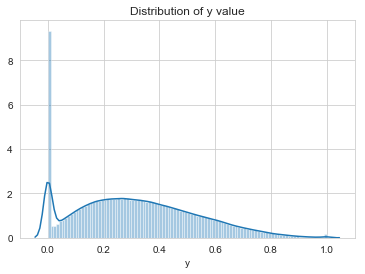

In [9]:
sns.distplot(df.y, bins = 100)
plt.title("Distribution of y value")
plt.show()

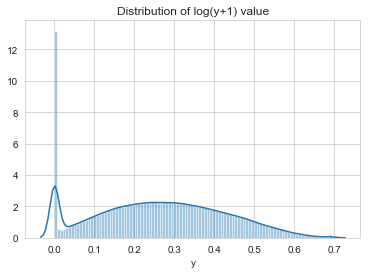

In [10]:
## Checking with log value of y+1
sns.distplot(np.log1p(df.y), bins = 100)
plt.title("Distribution of log(y+1) value")
plt.show()

Most sales are near zero. Also as data is normalized taking log hasn't changed the distribution a lot. So not applying any more transformation to the y-value

Text(0.5, 1.0, 'Sales vs date')

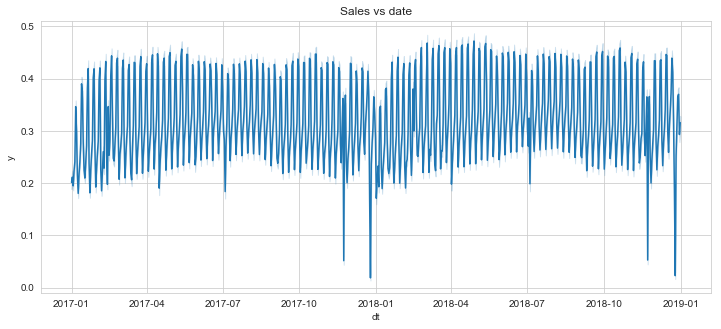

In [11]:
#Plotting sales vs date
plt.figure(figsize = (12,5))
sns.lineplot(x = 'dt', y = 'y', data = df)
plt.title('Sales vs date')

Seem like some seasonality in the sales with two major dips around same time of year. Most likely holidays, Thanksgiving, and Christmas. Also few other smaller dips probably around 4th July and other holidays. 

So adding holiday features should help with any predictive modeling.

Don't see much trend in this plot.

In [12]:
#Define function to add date features
def add_date_features(df):
    """
    Add date features to a dataframe and return modified dataframe
    """

    df['dayofmonth'] = df.dt.dt.day
    df['month'] = df.dt.dt.month
    df['year'] = df.dt.dt.year
    df['dayofyear'] = df.dt.dt.dayofyear
    df['weekofyear'] = df.dt.dt.weekofyear
    df['weekday'] = df.dt.dt.weekday #The day of the week with Monday=0, Sunday=6.
    
    return df

In [13]:
## Adding date features to the dataframe to find relationship between revenue and multiple date features and quick verification
df = add_date_features(df)
df.head(2)

,dt,y,id,dayofmonth,month,year,dayofyear,weekofyear,weekday
0,2017-01-01,0.0,0,1,1,2017,1,52,6
1,2017-01-02,0.0,0,2,1,2017,2,1,0


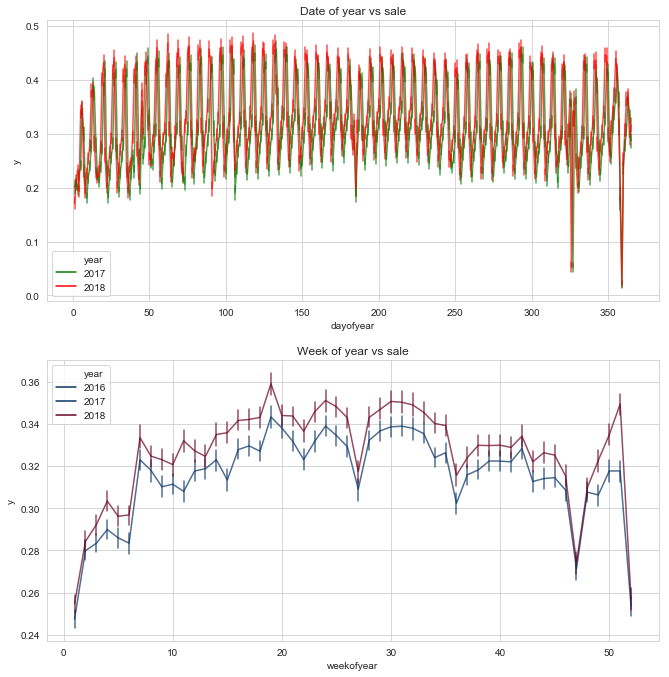

In [14]:
# Plotting the sale with the day features with separately by year to see any year on year trend

fig, ax = plt.subplots(2,1,figsize = (10,10))
fig.tight_layout(pad = 4)

ax[0].set_title("Date of year vs sale")
sns.lineplot(x = 'dayofyear', y ='y', data=df, hue = 'year', ax = ax[0], err_style = "bars", palette=['g','r'], alpha=0.7)

ax[1].set_title("Week of year vs sale")
sns.lineplot(x = 'weekofyear', y ='y', data=df, hue = 'year', ax = ax[1], err_style = "bars", palette='RdBu_r', alpha=0.7)
plt.show()

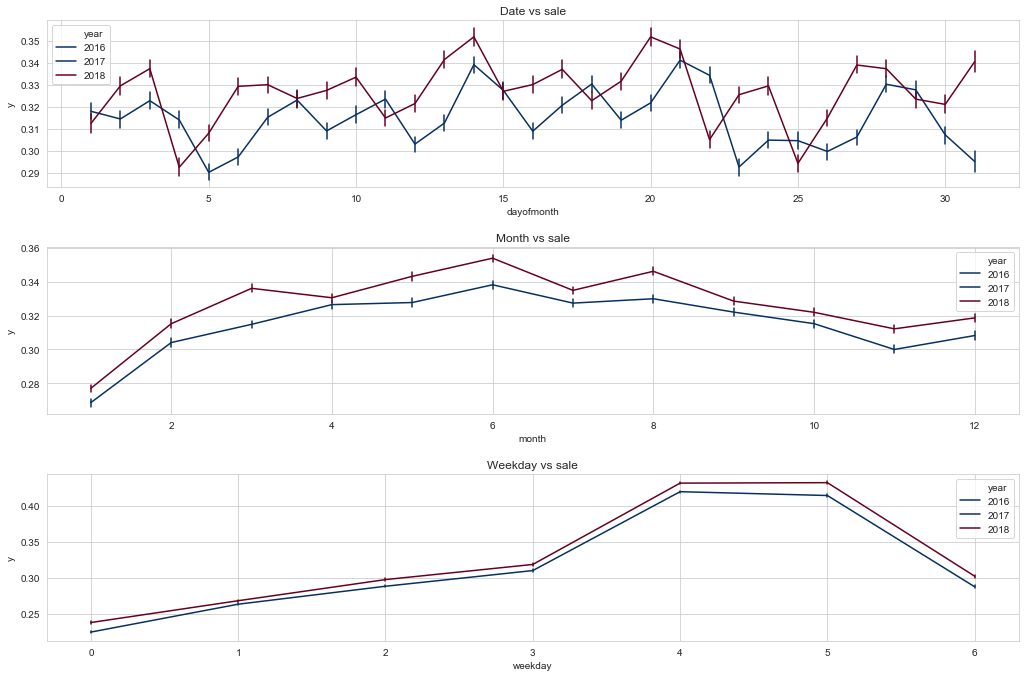

In [15]:
## Additional date feature plots
fig, ax = plt.subplots(3,1,figsize = (15,10))
plt.tight_layout(pad = 4)

sns.lineplot(x = 'dayofmonth', y ='y', data=df, hue = 'year', ax = ax[0], err_style="bars", palette='RdBu_r')
ax[0].set_title("Date vs sale")

sns.lineplot(x = 'month', y ='y', data=df, hue = 'year', ax = ax[1], err_style="bars", palette='RdBu_r')
ax[1].set_title("Month vs sale")

sns.lineplot(x = 'weekday', y ='y', data=df, hue = 'year', ax = ax[2], err_style="bars", palette='RdBu_r')
ax[2].set_title("Weekday vs sale")

plt.show()

#### Insights from above plots

Weekly sales are generally increasing over the year with highest sales in the middle weeks of year. Downward spikes in middle, and later half/start of of year. Probably 4th of July, thanksgiving, and Christmas time, and new year eve.

The average monthly sales is increasing year on year. Same goes for same day sale between year 2017 and 2018. **Booming economy?**

Within the year, the sales are generally higher in middle months and drop towards the end and beginning of year. **Dependent on season. Assuming US restaurants, summer sales should generally be higher**

In a weekday, the sales are higher on Friday and Saturday (0 - Monday, 6- Sunday). Since these are restaurants, makes logical sense that they have more sales on weekends. Though some restaurants who cater to office crowd, the trend might be opposite.

Not much info garnered from day of month given week of day is more important here.


In [16]:
df.dt.min(), df.dt.max()
## Not sure why year 2016 is also showing in some plot legend. Not a big problem though

(Timestamp('2017-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

#### Plotting sales of some randomly selected restaurants

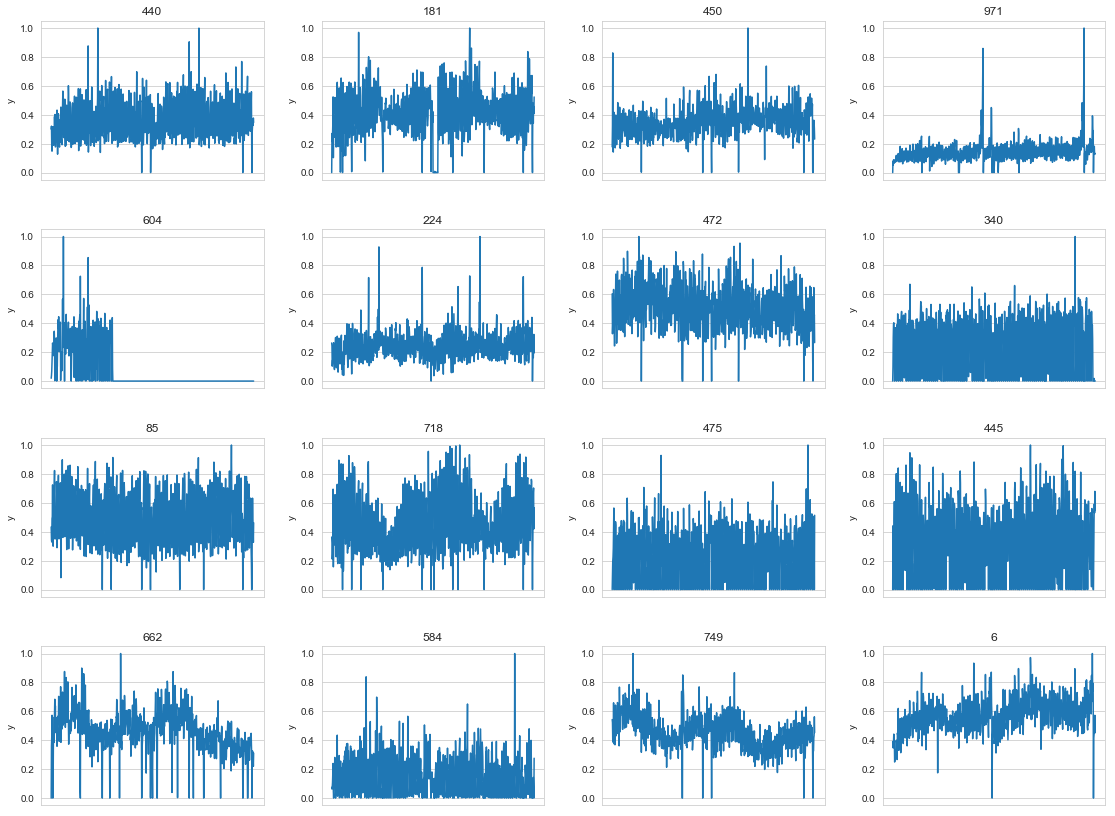

In [17]:
fig, axes = plt.subplots(4,4, figsize = (16,12))
plt.tight_layout(pad = 3)

for i1,i2 in itertools.product(np.arange(4), np.arange(4)):
    res = df.sample().id.values[0]
    sns.lineplot(x = 'dt', y = 'y',ax = axes[i1,i2], data = df[df.id == res])
    axes[i1,i2].set_title(res)
    axes[i1,i2].set_xlabel('')
    axes[i1,i2].set_xticks([])

As we can see each restaurant has a very different distribution of sales over the year. Some have seasonal component, some don't.

**Looks like using traditional time series methods might be quite complex in this case.**

Daily sales might also be too noisy. Also as seen it's quite influenced by the day of week and holidays. So calculating the average weekly sales per restaurant for a quick analysis

In [18]:
df_weekly = df[['dt', 'id', 'y']].groupby('id').resample('W', on = 'dt').mean().reset_index()
df_weekly.head(2)

,id,dt,y
0,0,2017-01-01,0.00000
1,0,2017-01-08,0.27239


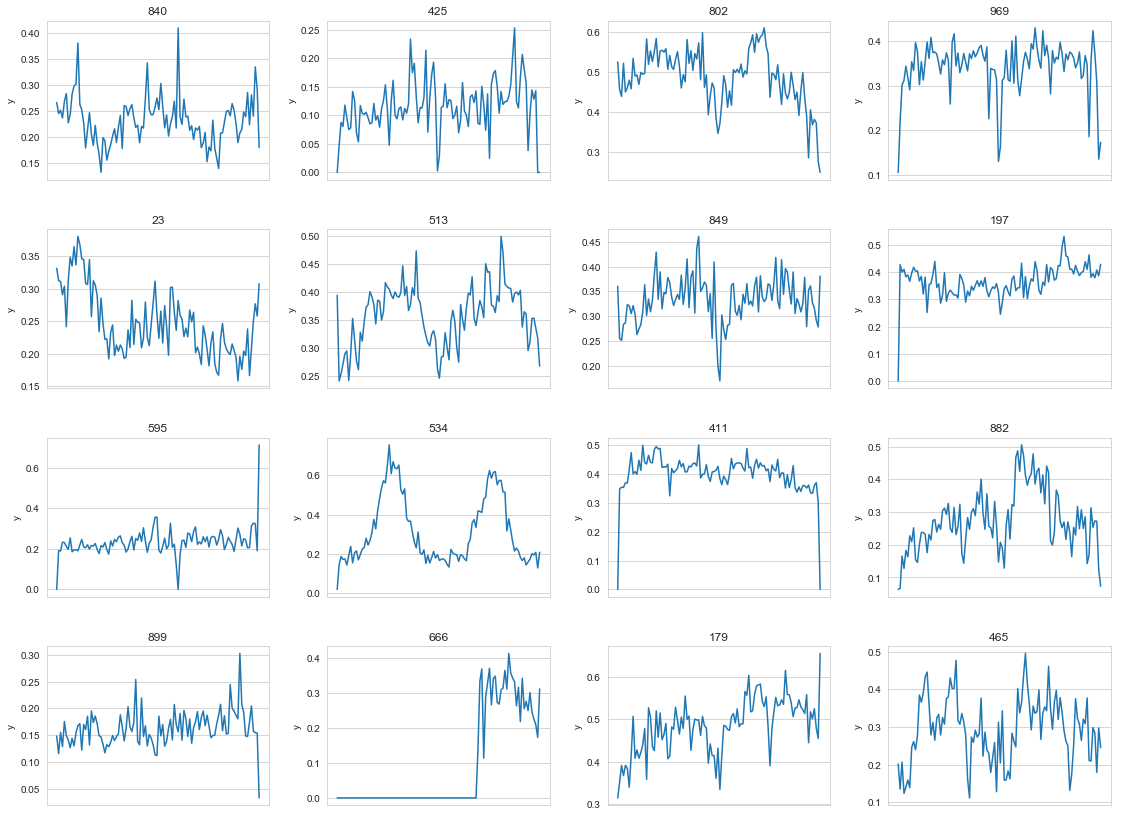

In [19]:
## Creating weekly revenue plots
fig, axes = plt.subplots(4,4, figsize = (16,12))
plt.tight_layout(pad = 3)

for i1,i2 in itertools.product(np.arange(4), np.arange(4)):
    res = df_weekly.sample().id.values[0]
    sns.lineplot(x = 'dt', y = 'y',ax = axes[i1,i2], data = df_weekly[df_weekly.id == res])
    axes[i1,i2].set_title(res)
    axes[i1,i2].set_xlabel('')
    axes[i1,i2].set_xticks([])

**Still quite noisy with no common pattern. Goes on to show how volatile is the restaurant business.**

Will try creating rolling average charts later if find time.

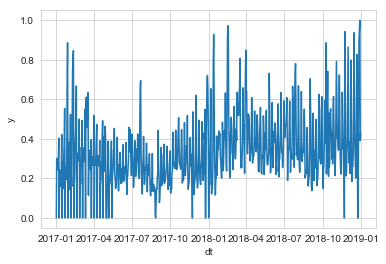

In [20]:
#Plotting one restaurant for some closer look
#555, 178
sns.lineplot(x = 'dt', y = 'y',data = df[df.id == 555])

#### Checking for some more statistics for the analysis

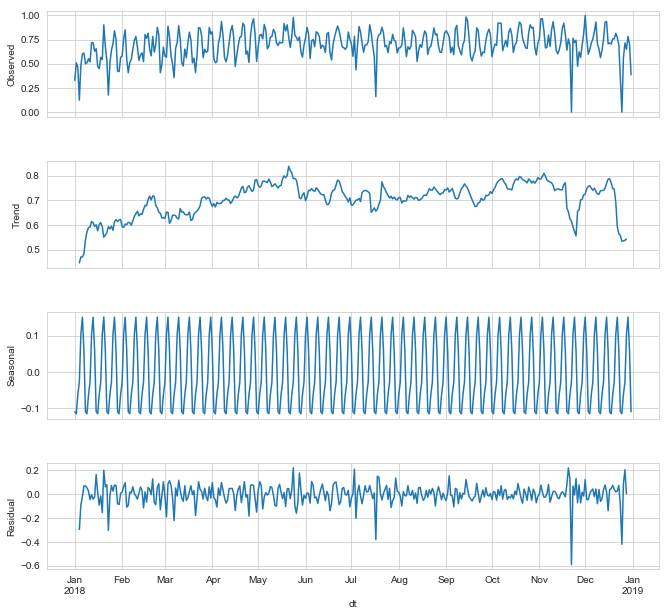

In [21]:
## Checking the decomposition for the time series for just one year using seasonal decompose from statsmodel package

df2 = df.sort_values(by = 'dt').set_index('dt').copy()
df2 = df2[(df2.id == 740) & (df2.year == 2018)][['y']] ## picked up multiple restaurants randomly to compare.

decomposition = sm.tsa.seasonal_decompose(df2, model='additive')
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

Check for stationarity, trend, and seasonality

There's a small trend in the data of most restaurant.
There's clear weekly seasonality in the data.
Some of the residuals are also not completely random.

Checking below for stationarity using augmented dicky-fuller test. The Null hypothesis is that series is non-stationarity.

In [22]:
## Checking for stationarity 
from statsmodels.tsa.stattools import adfuller

for _ in range(5):
# for restaurant in ['363', '452', '86', '407', '503']:
    res = df.sample().id.values[0]
    df_adfuller = df[df.id == res][['id', 'dt', 'y']].sort_values(by = 'dt').set_index('dt')
    dftest = adfuller(df_adfuller.y, autolag='AIC', maxlag = 20)
    print("p value for ad-fuller stationarity test for restaurant {} is {} :".format(res, dftest[1]))

p value for ad-fuller stationarity test for restaurant 40 is 0.0008610416151099954 :
p value for ad-fuller stationarity test for restaurant 335 is 0.18582024138199793 :
p value for ad-fuller stationarity test for restaurant 806 is 0.004388181039328962 :
p value for ad-fuller stationarity test for restaurant 602 is 0.0014576080929853876 :
p value for ad-fuller stationarity test for restaurant 514 is 0.0003416771528455216 :


#### As can be seen the time series is very different for each restaurant. So using traditional time series methods like ARIMA will require different treatment for each restaurant's revenue prediction. 

Also using such methods will require creating a separate time series for all 1000 restaurants which would be onerous as well as difficult to deploy and maintain.

We can use the differencing and other methods to try to make the series stationary. Though it'll make the prediction  complicated which I'll discuss later.

#### So for this exercise I'll take the machine learning approach to solve this problem.

Also skipping the auto-correlation analysis for this exercise.




## Modeling

#### Define Metric

I'll use root mean squre error in this model as looking at data points there were quite a few outliers. To reduce the effect of outliers and generalize the model, RMSE will be used as error metric in this model.

In acutal project, I'll also use MAE, and MAPE also. Skipping it for this exercise.

#### Validation

* We can use the last 3 months for data for validation for this exercise. i.e 2018/10, 2018/11, 2018/12 .

* Or we can also choose the Jan 2018, Feb 2018 as our validation sets as it mirrors our prediction set.

We'll go with the former approach in this problem with split date of **09/30/2018**.

**Ideally would have used n-fold cross validation, by training and validating over a moving window of 3-4 months over data of this size.**

Also not setting aside a test set for this exercise for now. Will come back if time allows.

#### Creating a base model

Using the rolling sales over last 30 days as our baseline model.

In [23]:
#Define metric
def rmse(y_true, y_predict):
    return np.sqrt(mean_squared_error(y_true, y_predict))

#Select index for splitting train and validation dataframe
val_split_date = pd.Timestamp(2018, 9, 30)

train_mask = (df.dt <= val_split_date)
val_mask = ~train_mask

print("Minimum date in validation data: {} and maximum date in train data: {}".format(df[val_mask].dt.min(), df[train_mask].dt.max()))

Minimum date in validation data: 2018-10-01 00:00:00 and maximum date in train data: 2018-09-30 00:00:00


In [24]:
## Creating the base model with rolling average of last 30 days as predictor

y_predict_base_val =  df.groupby('id')['y'].rolling(30).mean().reset_index(drop = True)[val_mask]
y_true_val = df[val_mask].y

print("RMSE on base model: ", rmse(y_true_val, y_predict_base_val))
print("This is the base score we would want to beat!!!")

RMSE on base model:  0.16248222933394751
This is the base score we would want to beat!!!


### Adding features

Start with adding the holiday feature as we saw it's dependent on holidays.

Also creating lag, difference, and rolling means to the data.

Also skipping training model on every step.

In [25]:
## adding holidays https://gist.github.com/shivaas/4758439
# holidays = pd.read_clipboard(sep = "," , names = ['_', 'date' ,'holiday']).drop('_', axis = 1)
# holidays.to_csv('US_holidays.csv', index = False)

In [26]:
def add_holidays(df):
    holidays = pd.read_csv('US_holidays.csv', parse_dates = ['date'])
    holidays = holidays.rename(columns = {'date': 'dt'})
    df = df.merge(holidays, how = 'left', on = 'dt')

    df.holiday = df.holiday.astype('category')
    return df

In [27]:
# Creating some lag and shift variables per restaurant below.
def add_lag_features(df):
    
    #Add shift and difference variable by 1
    df['y_shift1'] = df.groupby('id')['y'].shift(1)
    df['y_shift1_diff'] = df.y - df.y_shift1
    
    #Add shift and difference variable by 7
    df['y_shift7'] = df.groupby('id')['y'].shift(7)
    df['y_shift7_diff'] = df.y - df.y_shift7
    
    #Adding rolling mean for last 7 days
    df['y_rolling7'] = df.groupby('id')['y'].rolling(7).mean().reset_index(drop = True)
    
    #Adding rolling mean for last 14 days
    df['y_rolling14'] = df.groupby('id')['y'].rolling(14).mean().reset_index(drop = True)
    
    return df
    
    ##Additional features that can be created are exponentially weighted average and higher level differentiation

In [28]:
df = add_holidays(df)
df = add_lag_features(df)

df.head(2)

,dt,y,id,dayofmonth,month,year,dayofyear,weekofyear,weekday,holiday,y_shift1,y_shift1_diff,y_shift7,y_shift7_diff,y_rolling7,y_rolling14
0,2017-01-01,0.0,0,1,1,2017,1,52,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,0.0,0,2,1,2017,2,1,0,New Year Day,0.0,0.0,NaN,NaN,NaN,NaN


We have the lag features now in the data for model to use that for getting better results. 

**However, in this exercise, where we have to predict using our model on an entirely new time frame, the predictions will have to be *created one row at a time* and then used to create the lag, difference, and the rolling average for the next set of predictions. To stay within the timelimits of the exercise, I'll skip this approach and use only the direct variables to predict for the future time frame.**

Will run the model once just to check out it's results though.

Starting with only the base variables, date features, and holiday features

### Using the LightGBM model for this exercise

LightGBM has consistenly been one of the best performing model over most other models in recent times as seen in data science competitions. It also comes with multiple calibration options and easy to deploy too. Another option is a fully connected neural network.

Apart from these, now **LSTM** models are also being extensively used for time series forecast due to their inherent nature of having a long term and short term memory.


#### LGBM specific info

* Will be running the model with mostly defualt parameters in beginning.
* Use validation dataset for early stopping.
* Watch the metric on every train and val dataset
* Use the *auto categorical features* parameter of LGBM for the categorical features in our dataset
* Normally would use One Hot Encoder(OHE)the categorical variable. If the above doesn't gives good results, will use OHE.

In [29]:
## Details of model and function below this cell

def train(train_df,val_df, cols_to_keep:list, num_round=2000):
    
    print("Training started..")
    
    train_cols = [col for col in cols_to_keep if col not in ['dt', 'y']]
    
    # one_hot_encode_columns = ['id', 'month', 'weekday', 'holiday']
    # final_df = pd.get_dummies(merge_df[cols_to_keep],columns = one_hot_encode_columns )

    train_data = lgb.Dataset(train_df[train_cols], label = train_df.y)
    val_data = lgb.Dataset(val_df[train_cols], label = val_df.y)
    
    #Using mostly default hyperparameters for now
    params = {
    'metric': 'rmse', 
    'objective': 'regression',
    'verbosity': 1,
    'boosting_type': 'gbdt',
   'learning_rate': 0.01,
    'random_value': 123       
            }
    
    model = lgb.train(params, train_data, num_boost_round = num_round, verbose_eval=400, 
                      valid_sets = [train_data, val_data],  early_stopping_rounds = 400)
    
    return model


#This function to draw the output of model on validation set
def plot_predictions(df, model, train_cols):
    df['y_pred'] = model.predict(df[train_cols])

    fig,ax = plt.subplots(1,1,sharey = True, figsize = (8,5))
    sns.lineplot(x = 'dt', y = 'y',data = df, ax = ax, color = 'r' ,label = 'actual', err_style=None )
    sns.lineplot(x = 'dt', y = 'y_pred',data = df, ax = ax, color = 'g',label = 'prediction', err_style=None )
    plt.title("Acutal vs prediciton on validation dataset")
    ax.set_xlabel(None);ax.set_ylabel(None);plt.show()

In [30]:
#Skipping year as it's never going to repeat and also dayofmonth for now

cols_to_keep = ['dt','y','id', 'month','dayofyear','weekofyear', 'weekday', 'holiday']
train_cols = [col for col in cols_to_keep if col not in ['dt', 'y']]

train_df = df[train_mask]
val_df = df[val_mask]
model = train(train_df,val_df,cols_to_keep)

Training started..
Training until validation scores don't improve for 400 rounds.
[400]	training's rmse: 0.113545	valid_1's rmse: 0.131835
[800]	training's rmse: 0.104614	valid_1's rmse: 0.124785
[1200]	training's rmse: 0.101257	valid_1's rmse: 0.121837
[1600]	training's rmse: 0.0988875	valid_1's rmse: 0.120469
[2000]	training's rmse: 0.0972573	valid_1's rmse: 0.119657
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.0972573	valid_1's rmse: 0.119657


#### Got a much better RMSE than our base model.

Looks like there is a bit of overfitting. Can add regularization parameters to it later.

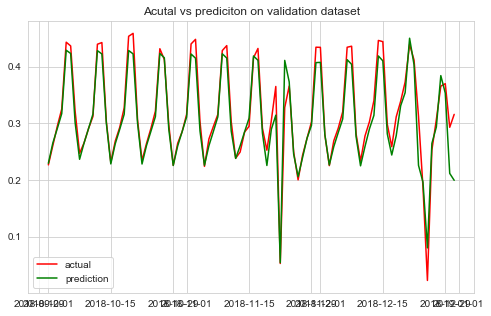

In [31]:
#Plot predictions on validation dataset
plot_predictions(val_df, model,train_cols)

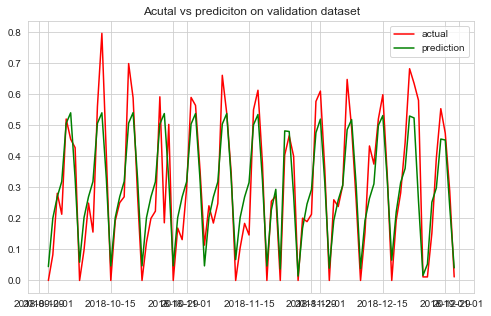

In [32]:
##PLot for one restaurant on validation dataset
plot_predictions(val_df[val_df.id == 0], model, train_cols)

## The prediction is not too bad on overall and restaurant-wise validation dataset

In [33]:
## Training on all columns as discussed before

cols_to_keep2 = ['dt','y','id', 'month','dayofyear','weekofyear', 'weekday', 'holiday','y_shift1', 'y_shift1_diff', 'y_shift7',
       'y_shift7_diff', 'y_rolling7', 'y_rolling14']
train_cols2 = [col for col in cols_to_keep2 if col not in ['dt', 'y']]

train_df = df[train_mask]
val_df = df[val_mask]

model2 = train(train_df,val_df, cols_to_keep2)

Training started..
Training until validation scores don't improve for 400 rounds.
[400]	training's rmse: 0.0145949	valid_1's rmse: 0.013196
[800]	training's rmse: 0.00935662	valid_1's rmse: 0.00765916
[1200]	training's rmse: 0.0078841	valid_1's rmse: 0.00677238
[1600]	training's rmse: 0.0072413	valid_1's rmse: 0.00638553
[2000]	training's rmse: 0.00660038	valid_1's rmse: 0.00617707
Did not meet early stopping. Best iteration is:
[2000]	training's rmse: 0.00660038	valid_1's rmse: 0.00617707


The RMSE is off the charts on validation dataset. Also looks like there isn't much overfitting as training and validation rmse is almost equal. Could do some regularization to be careful. 

**Won't be using this model however, as it would be required to do the prediction on every step of time series which will require more time to implement than can be allocated for this exercise.**

**Hence, using the first model for prediction over prediction time period.**

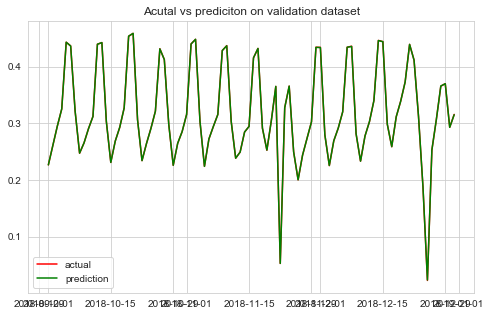

In [34]:
#Plot predictions on validation dataset for new model
plot_predictions(val_df, model2, train_cols2)



## The model is perfectly predicting the time series!!

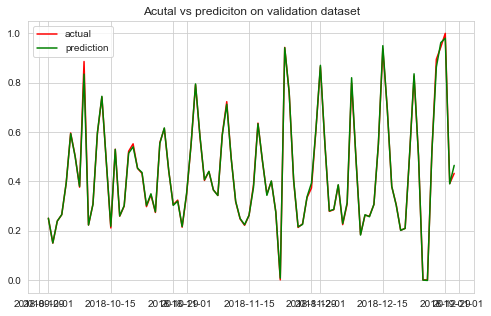

In [35]:
##PLot for one restaurant on validation dataset with new model

plot_predictions(val_df[val_df.id == 555], model2, train_cols2)

### Creating dataframe on which prediction will be made. 

**The description says 60 days from 2019-01-01 to 2019-02-27. Though there's only 58 days in that period. Using prediction period as per date as it's more logical (2 months)**

In [38]:
predict_date_range = pd.date_range(start = '1/1/2019', end = '2/27/2019', freq = 'D' )
print("Length of prediction window",len(predict_date_range))

predict_df = pd.DataFrame(columns = ['dt', 'id'])

#Creating dataframe with time range and each restaurant
for i in range(data.id.min(), data.id.max() +1):
    temp_df = pd.DataFrame({
        'dt': predict_date_range,
        'id': len(predict_date_range)*[i]
    })
    predict_df = pd.concat([predict_df, temp_df], ignore_index = True)

##Adding features on which model is trained
predict_df = add_date_features(predict_df) 
predict_df = add_holidays(predict_df) 

##Changing id and holidays to categories
predict_df.id = predict_df.id.astype('category')
predict_df.holiday = predict_df.holiday.cat.set_categories(df.holiday.cat.categories)

predict_df['y'] = model.predict(predict_df[cols_to_keep])
predict_df.head(2)    

Length of prediction window 58


KeyError: "['y'] not in index"

In [37]:
predict_df[['dt', 'id', 'y']].to_csv("rest_rev_submission_AS.csv", index = False)
predict_df.head(2)

KeyError: "['y'] not in index"

#### Next Steps

* Tune the hyperparameters of LGBM
* Create row-wise prediction to be able to use the lag, difference, and rolling average variables
* Try LSTM
* Wanting to use Prophet. Can try on this data.

### End of exercise

### Additional details

As we saw earlier, the time series wasn't stationary for many restaurants. In such as case, it's a good idea to difference the time series and use that as a target variable. We didn't do it in this case as it would require to do row wise prediction on prediction dataframe. However, just checking the augmented dickey fuller test on the differenced time series.

In [ ]:
##Checking for stationarity again randomly for 5 restaurants using ad-fuller test
# df_adf_test = df.copy()
# df_adf_test = df_adf_test[df_adf_test.y_shift1_diff.notna()]

for _ in range(5):
    res = df.sample().id.values[0]
    df_adfuller = df[df.id == res][['id', 'dt', 'y_shift1_diff']].sort_values(by = 'dt').set_index('dt')
    df_adfuller = df_adfuller[df_adfuller.y_shift1_diff.notna()]
    dftest = adfuller(df_adfuller.y_shift1_diff, autolag='AIC', maxlag = 20)
    print("p value for ad-fuller stationtionrity test for restaurant {} is {} :".format(res, dftest[1]))
    
    
## Stationarity almost disappeared with one order of differencing.    

A few guiding questions that you should be ready to think about:
* What metric do you use to define performance? What is your experimental setup?
     * _Explained earlier_
     
* What would your next steps be for deploying your model to production
     * I've used REST APIs to deploy the model using Python and flask. Once the application is developed, use docker to create the image which can be run as container on multiple platform. Though actual depends on organization infrastructure.
     
* Toast’s data in reality is not uniformly time lengthed of two years; some restaurants have just joined Toast, while others have been on the platform for many years. How would your approach change for restaurants with only a few months of data?
      * Some options --:
      * Look for similar restaurants and use them for as proxy.
      * Model those restaurants separately.
      * Club some restaurants together and predict their revene together.
      
* What additional data are you interested in getting, and how would you incorporate it?
      * Some options --:
      * The restaurant business is very economic dependent. Add economic variables to the data. 
      * Also add restaurant characterstics, like open days, open time, kind of restaurant (fast casual, fine dining, bar etc.)
      * Add competition details.. geographical and demographical indicators.. population
      * Add encvironmental factors.. if there's a bad weather stretch, or a major environmental event, that would affect the business.
      * Add real time variables.. such as a concert or event in the area.

## End